## AT1 Example I: Search problem (Due Week 6)
The following is the library used for the experiment.

In [1]:
import random
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Define three classes to store information about scheduling policies, machines and artifacts.

In [2]:
class Schedule:
    def __init__(self, num_machines):
        # The machine arrangement of the current scheduling policy
        self.machines = [Machine(i) for i in range(num_machines)]
        # The total delay of the current scheduling policy
        self.delay = 0


class Machine:
    def __init__(self, i):
        # Machine id
        self.id = i
        # The working schedule of the current machine
        self.tasks = []


class Object:
    def __init__(self, e, p, d):
        # The time when the workpiece reaches the machine
        self.entryTime = e
        # The time when the workpiece needs to be machined
        self.processingTime = p
        # The time when the workpiece is required to be delivered
        self.deliveryTime = d

Initializes a sequential sequence.

In [3]:
def initSchedule(jobs, numMachines):
    n = len(jobs)
    # Create a scheduling policy object
    bestSchedule = Schedule(numMachines)

    # Assign tasks to machines to a sequence structure
    for i in range(n):
        machineId = i % numMachines
        bestSchedule.machines[machineId].tasks.append(i)

    # recalculate schedule delay
    bestSchedule.delay = calcTotalDelay(bestSchedule, jobs)
    return bestSchedule

Find an adjacency state `newSchedule` by using the following function.

In [4]:
def neighbor(schedule, jobs):
    # Create a scheduling policy object
    newSchedule = Schedule(len(schedule.machines))

    # Deep copy of each machine's task assignment to prevent contamination of current scheduling
    for i, machine in enumerate(schedule.machines):
        newSchedule.machines[i].tasks = machine.tasks[:]

    # Swap any task between any two machines
    machine1, machine2 = random.sample(newSchedule.machines, 2)
    if machine1.tasks and machine2.tasks:
        task1, task2 = random.choice(machine1.tasks), random.choice(machine2.tasks)
        machine1.tasks[machine1.tasks.index(task1)], machine2.tasks[machine2.tasks.index(task2)] = task2, task1

    # Recalculate schedule delay
    newSchedule.delay = calcTotalDelay(newSchedule, jobs)
    return newSchedule

The following method is used to print the scheduling policy.

In [5]:
def printSchedule(schedule, jobs):
    # calculate the total delay of the certain schedule
    totalDelay = calcTotalDelay(schedule, jobs)

    # Iterate through each machine in the schedule
    for machine in schedule.machines:
        print(f"Machine {machine.id}:")

        # Iterate through each task assigned to the machine
        for i in range(len(machine.tasks)):
            job = jobs[machine.tasks[i]]
            # Print details of each task on the current machine
            print(f" No.{i + 1} : {job.entryTime} {job.processingTime} {job.deliveryTime}")

    # Print the total delay calculated earlier
    print(f"Total delay: {totalDelay}")

Calculates the latency of a particular scheduling policy.

In [6]:
def calcTotalDelay(schedule, jobs):
    totalDelay = 0

    # Iterate through each machine in the schedule
    for machine in schedule.machines:
        now = 0

        # Iterate through each task assigned to the machine
        for taskId in machine.tasks:
            job = jobs[taskId]

            # Process the job and update the current time
            now = max(now, job.entryTime)
            now += job.processingTime

            # Calculate the delay if the job's completion time exceeds its delivery time
            if now > job.deliveryTime:
                totalDelay += now - job.deliveryTime

    return totalDelay

`hillClimbing(init, neighbor, jobs, data, times=500, iteration=1000)`is the core algorithm and implements the hill climbing algorithm.

In [7]:
def hillClimbing(init, neighbor, jobs, data, times=500, iteration=1000):
    # Initialize the current state
    current = init
    # Initialize a counter to track the number of consecutive unsuccessful searches
    count = 0

    while iteration:
        # Generate a neighboring state
        nextChoice = neighbor(current, jobs)
        if not nextChoice:
            break

        # If the counter exceeds the `times` threshold, break the loop
        if count > times:
            break

        # If the next choice has a lower total delay, update the current state and append the delay to the data list
        if calcTotalDelay(nextChoice, jobs) < calcTotalDelay(current, jobs):
            current = nextChoice
            data.append(current.delay)

            # Reset the counter for successful updates
            count = 0
        else:
            # Increment the counter for unsuccessful updates
            count += 1
        iteration -= 1

    return current

`simulatedAnnealing(init, neighbor, schedule, jobs)` is the core algorithm and implements the simulated annealing algorithm.

In [8]:
def simulatedAnnealing(init, neighbor, schedule, jobs, data):
    # Initialize the current state
    current = init

    for t in range(sys.maxsize):
        # Get the temperature for the current iteration
        T = schedule()(t)

        # Stop the algorithm if T drops to a certain temperature
        if T == 0:
            break

        # Generate a neighboring state
        nextChoice = neighbor(current, jobs)
        if not nextChoice:
            break

        deltaE = nextChoice.delay - current.delay
        # If the total delay of the new state is less than the total delay of the current state, select the new state.
        # Otherwise, the original state will be retained with a certain probability, which is temperature-dependent
        if deltaE < 0 or probability(np.exp(-deltaE / T)):
            current = nextChoice
            data.append(current.delay)

    return current

In [9]:
def probability(p):
    # If the randomly generated number is less than or equal to p, return True, indicating that the event occurred;
    # Otherwise, False is returned, indicating that the event does not occur.
    return random.uniform(0.0, 1.0) < p

The cooling formula:
$f(T)=\left\{\begin{matrix}k*exp^{(-lam*T)}, T<\#limit\\0,otherwise\end{matrix}\right.$

In [10]:
def expSchedule(k=20, lam=0.005, limit=10000):
    """
    Exponential decay temperature scheduler
    Parameters:
        k (float, optional): initial temperature.
        lam (float, optional): attenuation rate.
        limit (int, optional): indicates the upper limit of temperature attenuation.
    """
    return lambda t: k * np.exp(-lam * t) if t < limit else 0

Import data from `test.csv` and consolidate it into a list

In [12]:
# The number of machines
numMachines = 3
# The list of workpieces to be processed
jobs = []
# The iteration data of the hill climbing algorithm
HCData = []
# The iteration data of the simulated annealing algorithm
SAData = []

# Read the data from the CSV file
df = pd.read_csv("data.csv")
for x, y, z in zip(df["entryTime"], df["processingTime"], df["deliveryTime"]):
    jobs.append(Object(x, y, z))

# Print the first few rows of the DataFrame
df.head()

,entryTime,processingTime,deliveryTime
0,0,15,21
1,0,19,25
2,0,26,30
3,0,9,13
4,0,15,24


Here the hill climbing algorithm is called and the run time is calculated

In [ ]:
startTime = time.time()
# Initialize an initial scheduling scheme
init = initSchedule(jobs, numMachines)
# Hill climbing algorithm was used to optimize the initial scheduling scheme
HCSchedule = hillClimbing(init, neighbor, jobs, HCData)
endTime = time.time()

# Print optimized scheduling scheme
printSchedule(HCSchedule, jobs)
print(f"time = {int((endTime - startTime) * 1000)} ms")

Machine 0:
 No.1 : 0 8 17
 No.2 : 0 11 14
 No.3 : 14 14 30
 No.4 : 6 12 19
 No.5 : 35 10 55
 No.6 : 35 8 63
 No.7 : 42 7 75
 No.8 : 24 12 65
 No.9 : 9 16 27
 No.10 : 19 17 44
 No.11 : 44 18 87
 No.12 : 17 18 40
 No.13 : 0 21 35
 No.14 : 34 23 58
 No.15 : 0 26 30
Machine 1:
 No.1 : 0 12 18
 No.2 : 0 15 24
 No.3 : 0 9 13
 No.4 : 11 12 25
 No.5 : 48 7 55
 No.6 : 45 11 65
 No.7 : 42 9 75
 No.8 : 34 16 61
 No.9 : 0 15 21
 No.10 : 17 17 38
 No.11 : 15 17 48
 No.12 : 12 19 33
 No.13 : 7 18 28
 No.14 : 0 23 67
 No.15 : 0 31 41
Machine 2:
 No.1 : 0 19 25
 No.2 : 17 11 28
 No.3 : 15 15 40
 No.4 : 15 13 28
 No.5 : 47 12 76
 No.6 : 34 6 75
 No.7 : 0 14 25
 No.8 : 25 17 42
 No.9 : 25 17 57
 No.10 : 7 17 27
 No.11 : 12 17 31
 No.12 : 14 20 38
 No.13 : 42 24 73
 No.14 : 47 41 89
Total delay: 2654
time = 99 ms


Here the simulated annealing algorithm is called and the run time is calculated

In [ ]:
startTime = time.time()
# Initialize an initial scheduling scheme
init = initSchedule(jobs, numMachines)
# Simulated annealing algorithm was used to optimize the initial scheduling scheme
SAschedule = simulatedAnnealing(init, neighbor, expSchedule, jobs, SAData)
endTime = time.time()

# Print optimized scheduling scheme
printSchedule(SAschedule, jobs)
print(f"time = {int((endTime - startTime) * 1000)} ms")

Machine 0:
 No.1 : 0 12 18
 No.2 : 11 12 25
 No.3 : 14 14 30
 No.4 : 0 15 21
 No.5 : 34 6 75
 No.6 : 35 8 63
 No.7 : 42 7 75
 No.8 : 34 16 61
 No.9 : 15 17 48
 No.10 : 25 17 42
 No.11 : 7 17 27
 No.12 : 0 19 25
 No.13 : 12 19 33
 No.14 : 0 23 67
 No.15 : 0 26 30
Machine 1:
 No.1 : 0 9 13
 No.2 : 6 12 19
 No.3 : 15 13 28
 No.4 : 0 14 25
 No.5 : 48 7 55
 No.6 : 45 11 65
 No.7 : 42 9 75
 No.8 : 47 12 76
 No.9 : 9 16 27
 No.10 : 17 17 38
 No.11 : 19 17 44
 No.12 : 7 18 28
 No.13 : 0 21 35
 No.14 : 34 23 58
 No.15 : 47 41 89
Machine 2:
 No.1 : 0 11 14
 No.2 : 0 8 17
 No.3 : 17 11 28
 No.4 : 15 15 40
 No.5 : 35 10 55
 No.6 : 24 12 65
 No.7 : 0 15 24
 No.8 : 12 17 31
 No.9 : 25 17 57
 No.10 : 17 18 40
 No.11 : 44 18 87
 No.12 : 14 20 38
 No.13 : 42 24 73
 No.14 : 0 31 41
Total delay: 2594
time = 492 ms


Print a line plot using matplotlib.pyplot for subsequent analysis.

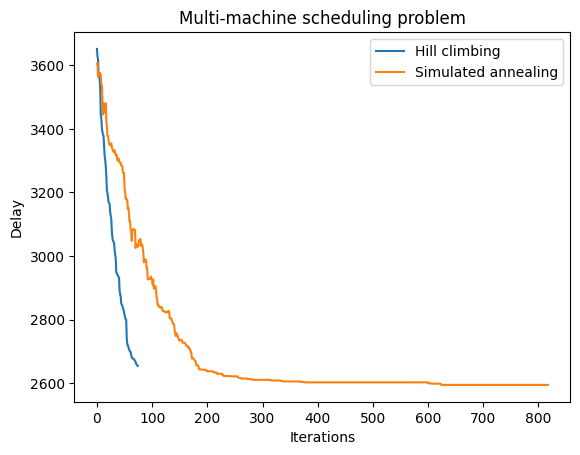

In [ ]:
plt.title("Multi-machine scheduling problem")
plt.xlabel("Iterations")
plt.ylabel("Delay")

plt.plot(range(len(HCData)), HCData)
plt.plot(range(len(SAData)), SAData)
plt.legend(labels=['Hill climbing', 'Simulated annealing'])

plt.show()

Adjust the parameters and analyze the performance under different parameters

k=1 lam=0.005 delay=2588
k=1 lam=0.05 delay=2592
k=1 lam=0.5 delay=2591
k=1 lam=5 delay=2597


<Figure size 640x480 with 0 Axes>

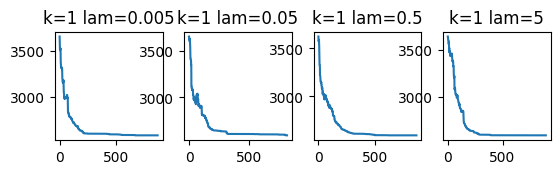

k=20 lam=0.005 delay=2625
k=20 lam=0.05 delay=2590
k=20 lam=0.5 delay=2606
k=20 lam=5 delay=2588


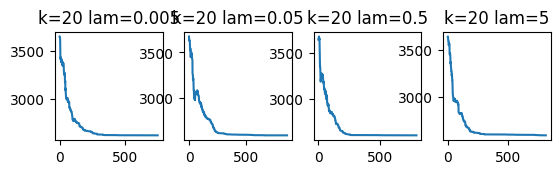

k=40 lam=0.005 delay=2625
k=40 lam=0.05 delay=2600
k=40 lam=0.5 delay=2601
k=40 lam=5 delay=2594


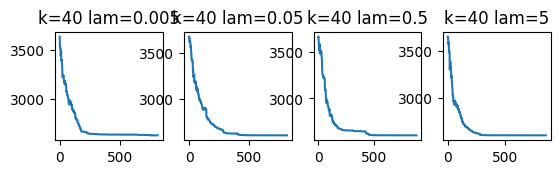

In [14]:
i = 0
plt.tight_layout()

# The k value to be tested
kValues = [1, 20, 40]
# The lam value to be tested
lamValues = [0.005, 0.05, 0.5, 5]

for k in kValues:
    fig = plt.figure()
    for lam in lamValues:
        i += 1
        data = []

        # Initialize an initial scheduling scheme
        init = initSchedule(jobs, numMachines)
        # Simulated annealing algorithm was used to optimize the initial scheduling scheme
        bestSchedule = simulatedAnnealing(init, neighbor, expSchedule, jobs, data)
        print(f"k={k} lam={lam} delay={bestSchedule.delay}")

        # Draws a subgraph of the specified k and lam values
        fig.add_subplot(len(kValues), len(lamValues), i)
        plt.title(f"k={k} lam={lam}")
        plt.plot(range(len(data)), data)
    plt.show()